# Výpočet odezvy při vázaném smrštění dle fib MC 2010

***

Vypracované řešení zašlete včetně scriptu nebo pomocných výpočtů na adresu petr.havlasek@cvut.cz<br>

Řešení je možné odezvdat do přespříštího cvičení.

Jako předmět zprávy uveďte **PRPM: BONUS**

***

## Zadání:

Deska z prostého betonu tloušťky 200 mm se v jednom směru může volně zkracovat a ve druhém směru je neposuvně podepřená. Uvažujte beton třídy C30/37. Deska byla ošetřována po dobu 7 dní a poté byla vystavena prostředí s průměrnou hodnotou relativní vlhkosti 50\%. Účinky vlastní tíhy, dalšího nahodilého zatížení a autogenního smrštění zanedbejte. Dále předpokládejte, že vlivem vysychání dochází ke smršťování, které namáhá celý průřez stejnoměrně.

Předpokládejte, že tahová pevnost betonu se vyvíjí dle doporučení MC 2010 a není redukována dlouhodobým zatížením. Střední tahová pevnost betonu ve stáří 28 dnů je pro třídu do C50 aproximována výrazem

$f_{ctm,28} = 0.3 \left(f_{ck}\right)^{2/3}$

kde $f_{ck}$ je charakteristická hodnota tlakové pevnosti v tomto stáří. Pro jednoduchost předpokládejte, že vývoj tahové pevnosti se řídí stejnou funkcí jako tlaková pevnost, tj. $f_{ctm}(t) = \beta_{cc}(t) f_{ctm,28}$, kde funkce $\beta_{cc}(t)$ je definována dála v tomto notebooku (buňka pro výpočet modulu pružnosti).

Vaším úkolem je vykreslit vývoj napětí způsobeného smršťováním od vysychání. Do jednoho grafu vykreslete vývoj napětí za předpokladu, že beton dotvaruje a dále pro případ, že je jeho chování idealizováno jako lineárně pružné s tuhostí rovnou sečnovému modulu. Do stejného obrázku nakreslete vývoj tahové pevnosti betonu dané třídy a vývoj předepsaného smrštění.

Stanovte délku vysychání, při které tahové napětí dosáhne tahové pevnosti betonu.



Pro výpočet napětí můžete využít vztah 1.89 ze skripta PRPM. Relaxační funkci vyhodnoťe vždy v polovině časového intervalu.

Pro Vaše řešení můžete využít vykreslení v poslední buňnce tohoto notebooku.

Notebook obsahuje potřebné i nepotřebné informace a grafy.

Pozn: vyhodnocení napětí za předpokladu relaxace je poměrně náročná úloha a její výpočet může trvat několik vteřin (v závislosti na časové diskretizaci)



# fib Model Code 2010: creep and shrinkage

Implementation of expressions from fib bulletin 65: Model Code 2010, Final draft, Volume 1, 2012.
Relaxation function computed using equations (5.24)-(5.25) presented in Z.P. Bažant and M. Jirásek: Creep and Hygrothermal Effects in Concrete Structures, 2018


<div class="alert alert-block alert-danger">

## Range of applicability

- unreinforced concrete moist cured at normal temperature up to 14 days<br>

- age at loading $tt \geq$ 1 day<br>

- structural concrete with 20 MPa $\leq$ f_cm $\leq$ 130 MPa<br>

- stress level up to 0.4 $f_{cm}(tt)$ for linear creep<br>

- stress level 0.4-0.6 $f_{cm}(tt)$ for nonlinear creep<br>

- mean relative humidity 40-100%<br>

- mean temperature 5-30 C<br>
</div>



<div class="alert alert-block alert-info">

## Input parameters

### Material & Geometry
`fcm28` ... mean compressive strength of concrete measured on cylinders at the age of 28 days [MPa] <br>

`h` ... notional size [mm] reflecting cross section geometry and surface exposed to drying<br>

`aggregate type` ... basalt/quartzite/dense limestone/sandstone <br>

'cement type' ... (decision tree = first applicable criterion according to the composition)

* CS = CEM III, CEM II/B, strength class 32.5 N, 42.5 N, more than 65% of GGBS or more than 35% FA<br>

* CN = CEM II, CEM I, strength class 42.5 N, 32.5 R, more than 35% GGBS or more than 20 % FA<br>

* CR = CEM I, strength class 42.5 R, 52.5 N, 52.5 R

`t0` ... duration of curing = concrete age at the onset of drying<br>

### Loading

`RH` ... mean relative humidity of the environment [%]<br>

`tt` ... age at loading [day]<br>

`stress` ... magnitude of compression [MPa]<br>

</div>


## Imports

In [1]:
%matplotlib inline

import math
import numpy as np

import matplotlib.pyplot as plt

## Definition of Global Variables

In [2]:

# onset of drying (concrete age) [days]
t0 = 7

# concrete age at loading (default value) [days]
tt = 14

# magnitude of loading stress [MPa]
stress = 10

# mean compressive strength on cylinders at the age of 28 days [MPa]
fcm_28 = 38

# characteristic compressive cylinder strength of concrete at 28 days [MPa]
fck_28 = fcm_28 - 8

# relative humidity of the environment [%] (range of validity 20-100%)
RH = 50

# notional size of the member [mm] (h = 2*cross section / perim. of drying surface)
h = 200

# default value of parameters related to concrete composition

aggregate_type = "quartzite" 
# aggregate_type = "basalt"
# aggregate_type = "dense limestone"
# aggregate_type = "limestone"
# aggregate_type = "sandstone"


# CREEP-SPECIFIC PARAMETERS
# cement_type = "CS" 
cement_type = "CN" 
# cement_type = "CR"


# ASSIGNING MATERIAL PARAMETERS - DO NOT MODIFY

if (fcm_28 <= 60): # MPa
    
    if (cement_type == "CS"):
        s = 0.38

    elif (cement_type == "CN"):
        s = 0.25

    else: # R
        s = 0.20

else:
    s = 0.20

if (cement_type == "CS"):
    alpha = -1.

elif (cement_type == "CN"):
    alpha = 0.

else: # CR
    alpha = 1.
    
if (cement_type == "CS"):
    alpha_as = 800.
    alpha_ds1 = 3.
    alpha_ds2 = 0.013

elif (cement_type == "CN"):
    alpha_as = 700.
    alpha_ds1 = 4.
    alpha_ds2 = 0.012

else: # CR
    alpha_as = 600.
    alpha_ds1 = 6.
    alpha_ds2 = 0.012


if (aggregate_type == "basalt"):
    alpha_E = 1.2
    
elif (aggregate_type == "quartzite"): 
    alpha_E = 1.0

elif (aggregate_type == "dense limestone"): 
    alpha_E = 1.0

elif (aggregate_type == "limestone"):
    alpha_E = 0.9

else: #(aggregate_type == "sandstone")
    alpha_E = 0.7


In [3]:
# variables - time discretization and plotting

log_scale = True

t_div = 50 # default number of time points used for time integration etc.

t_aux_min = 1.e-2 
t_aux_max = 1.e3


# Functions in MC 2010

## Modulus of Elasticity

> Described in Section 5.1.7.2<br>

> $E_{cm}$ is defined as a tangent modulus of elasticity at the origin of the stress-strain diagram which is approximately equal to the slope of the unloading branch at 40% of the compressive strength<br>

> The value of Young's modulus at the age at loading is used to determine the instantaneous deformation while its value at 28 days, $E_{cm}(28)$ or `E_cm_28`, is used to compute the delayed deformation by means of the creep coefficient.


In [4]:
def compute_modulus_of_elasticity(t):

    E_c0 = 21.5e3
    
    E_cm_28 = E_c0 * alpha_E * ( fcm_28/10. )**(1./3.)  # 5.1-21
    
    beta_cc = math.exp( s * (1. - math.sqrt(28./t) ) ) # 5.1-51
    
    beta_E = math.sqrt(beta_cc) # 5.1-57
    
    E_cm_t = beta_E * E_cm_28 # 5.1-56

    return E_cm_t
    

## Creep Coefficient

In [5]:
def compute_creep_coeff(t,tt):
    
    phi_bc = compute_creep_coeff_basic(t, tt)
    phi_dc = compute_creep_coeff_drying(t, tt)
    
    return phi_bc + phi_dc

In [6]:
def compute_creep_coeff_basic(t, tt):

    beta_bc_fcm = 1.8 * fcm_28**(-0.7) # 5.1-65

    # adjusted age reflecting the cement type but (here) without temperature effect
    tt_adj = compute_adjusted_age(tt)

    if (t > tt):
        beta_bc_t_tt = math.log( (30./tt_adj + 0.035)**2. * (t-tt) + 1.) # 5.1-66
    else:
        beta_bc_t_tt = 0.
    
    phi_bc = beta_bc_fcm * beta_bc_t_tt # 5.1-64
    
    return phi_bc
    

In [7]:
def compute_creep_coeff_drying(t, tt):

    # adjusted age reflecting the cement type but (here) without temperature effect
    tt_adj = compute_adjusted_age(tt)
    #-------------------
    beta_dc_fcm = 412. * fcm_28**(-1.4) # 5.1-68
    #-------------------
    beta_RH = (1. - RH/100.) * (0.1 * h/100.)**(-1./3.) # 5.1-69
    #-------------------
    beta_dc_tt = 1. / (0.1 + tt_adj**0.2) # 5.1-70
    #-------------------
    gamma_tt = 1. / ( 2.3 + ( 3.5 / math.sqrt(tt_adj) ) ) # 5.1-71b

    alpha_fcm = math.sqrt(35./fcm_28) # 5.1-71d
    
    beta_h = min(1.5 * h + 250.*alpha_fcm, 1500 * alpha_fcm) # 5.1-71c
    
    beta_dc_t_tt = ( (t-tt) / ( beta_h + (t-tt) ) )**gamma_tt # 5.1-71a
    #-------------------                 
    phi_dc = beta_dc_fcm * beta_RH * beta_dc_tt * beta_dc_t_tt # 5.1-67
                   
    return phi_dc


In [8]:
def compute_adjusted_age(tt):
    # without temperature effect
    tt_adj = max( tt * ( 9./ ( 2. + tt**1.2 ) + 1. )**alpha, 0.5) # 5.1-73

    return tt_adj
    

In [9]:
def compute_total_compliance_function(t, tt):

    if (t < tt):
        J = 0.
    elif ( t == tt):
        E_cm_t = compute_modulus_of_elasticity(tt)
        J = 1./E_cm_t
    else:
        E_cm_t = compute_modulus_of_elasticity(tt)
        E_cm_28 = compute_modulus_of_elasticity(28.)
        
        # 5.1-63
        # sum of basic and drying creep coefficient
        phi = compute_creep_coeff(t,tt)
        
        # 5.1.61 
        J = 1./E_cm_t + phi/E_cm_28
    
    return J

def compute_basic_compliance_function(t, tt):

    if (t < tt):
        J = 0.
    elif ( t == tt):
        E_cm_t = compute_modulus_of_elasticity(tt)
        J = 1./E_cm_t
    else:
        E_cm_t = compute_modulus_of_elasticity(tt)
        E_cm_28 = compute_modulus_of_elasticity(28.)
        
        # 5.1-63
        phi = compute_creep_coeff_basic(t, tt) 
        
        # 5.1.61 
        J = 1./E_cm_t + phi/E_cm_28
    
    return J


## Compliance and Relaxation Functions

In [10]:
# use this function only to evaluate relaxation function at particular time 
def compute_total_relaxation_function(t, tt):

    if (t < tt):
        R = 0.
    elif (t == tt):
        R = compute_modulus_of_elasticity(tt)
    else:
        R_tot = np.zeros(t_div)
        
        # create array with loading durations [0., 0., logscale with t_div-2 entries]
        times = np.logspace( round(math.log10(t_aux_min))-1, ( math.log10(t-tt) ), num = t_div-2 )
        times = np.insert( times, 0, [0., 0.])
        
        times += tt # duration of loading changed to age

        # zero loading duration, times[1] = times[0]
        R_tot[1] = 1. / compute_total_compliance_function(times[1], times[0]) 
        # first non-zero loading duration
        R_tot[2] = 1. / compute_total_compliance_function(times[2], times[0])
   
        for k in range(2,t_div-1):
            
            sum = 0.
            for i in range(0,k-1):
                J_kplus1_i = compute_total_compliance_function( times[k+1], (times[i+1]+times[i])/2. ) 
                J_k_i = compute_total_compliance_function( times[k], (times[i+1]+times[i])/2. ) 
                delta_J_k_i = J_kplus1_i - J_k_i
                sum += delta_J_k_i * ( R_tot[i+1] - R_tot[i] )
    
            J_kplus1_k = compute_total_compliance_function( times[k+1], (times[k+1]+times[k])/2. )
            R_tot[k+1] = R_tot[k] - sum / J_kplus1_k
        
        # return the last value from the array which corresponds to the desired time "t"
        R = R_tot[-1]
    
    return R

## Mean Total Shrinkage

5.1.9.4.4: characteristic values corresponding to 5 and 95 percentile are 0.42 eps_cs and 1.58 eps_cs, respectively

In [11]:
def compute_mean_total_shrinkage(t):

    eps_cas = compute_mean_auto_shrinkage(t)
    eps_cds = compute_mean_drying_shrinkage(t)
    eps_cs = eps_cas + eps_cds # 5.1-75

    return eps_cs
    

### Mean Autogenous Shrinkage

In [12]:
def compute_mean_auto_shrinkage(t):

    if (t <= 0.):
        eps_cas = 0.
    else:
        # 5.1-78, notional autogenous shrinkage coefficient
        eps_cas_fcm = -alpha_as * ( fcm_28 / ( 60. + fcm_28 ) )**2.5 * 1.e-6
        # 5.1-79, development of autogenous shrinkage
        beta_as_t = 1. - math.exp( -0.2 * math.sqrt(t) )
        
        eps_cas = eps_cas_fcm * beta_as_t # 5.1-76

    return eps_cas

### Mean Drying Shrinkage

In [13]:
def compute_mean_drying_shrinkage(t):

    t_dry = t-t0
    
    if (t_dry <= 0.):
        eps_cds = 0.
    
    else:       
        # 5.1-80, notional drying shrinkage coefficient
        eps_cds_fcm = (220. + 110 * alpha_ds1) * math.exp(-alpha_ds2 * fcm_28) * 1.e-6
    
        # 5.1-83
        beta_s1 = min( (35./fcm_28)**0.1, 1.0 )
        
        # 5.1-81 effect of relative humidity on drying shrinkage
        if (RH < 99. * beta_s1): 
            beta_RH = -1.55 * (1. - (RH/100.)**3 )
        else: 
            beta_RH =  0.25
    
        # 5.1-82, development of drying shrinkage
        beta_DS_t_dry = math.sqrt( t_dry / (0.035 * h**2  + t_dry) )
    
        eps_cds = eps_cds_fcm * beta_RH * beta_DS_t_dry # 5.1-77

    return eps_cds

# Plotting

## Plot of a compliance function 

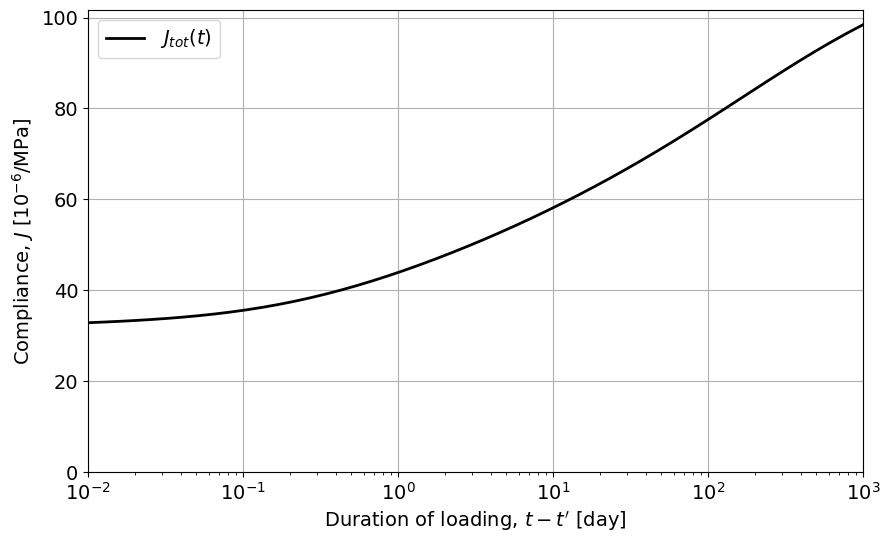

In [14]:
# prepare data
# times here is the duration of loading
times = np.logspace( round(math.log10(t_aux_min)), round(math.log10(t_aux_max)), num = t_div )

J_tot = np.zeros(t_div)
   
for i in range(t_div):
    # here t is shifted by the onset of loading
    t = times[i] + tt
    J_tot[i] =  compute_total_compliance_function(t, tt) 


plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})

plt.plot(times, J_tot * 1.e6, lw=2., color="black", label=r'$J_{tot}(t)$')


if (log_scale):
    plt.xscale('log')
    plt.xlim([t_aux_min, t_aux_max])
else:
    plt.xlim([0., t_aux_max])

# keep top range unbounded
plt.ylim(bottom = 0)

plt.grid(True)
plt.legend()
plt.xlabel('Duration of loading, $t-t\'$ [day]')
plt.ylabel('Compliance, $J$ [$10^{-6}$/MPa]')

plt.savefig('fib_MC2010_compliance_function.pdf')

plt.show()



## Plot of a relaxation function 

In [15]:
def evaluate_relaxation_function_at_times(ages):        

    aux = ages[0]
    ages = np.insert( ages, 0, [aux, aux])
   
    R_tot = np.zeros(len(ages))
    # zero loading duration, times[1] = times[0]
    R_tot[1] = 1. / compute_total_compliance_function(ages[1], ages[0]) 
    # first non-zero loading duration
    R_tot[2] = 1. / compute_total_compliance_function(ages[2], ages[0])
    
    for k in range(2,len(ages)-1):
        
        sum = 0.
        for i in range(0,k-1):
            J_kplus1_i = compute_total_compliance_function( ages[k+1], (ages[i+1]+ages[i])/2. ) 
            J_k_i = compute_total_compliance_function( ages[k], (ages[i+1]+ages[i])/2. ) 
            delta_J_k_i = J_kplus1_i - J_k_i
            sum += delta_J_k_i * ( R_tot[i+1] - R_tot[i] )

        J_kplus1_k = compute_total_compliance_function( ages[k+1], (ages[k+1]+ages[k])/2. )
        R_tot[k+1] = R_tot[k] - sum / J_kplus1_k

    return R_tot[2:]

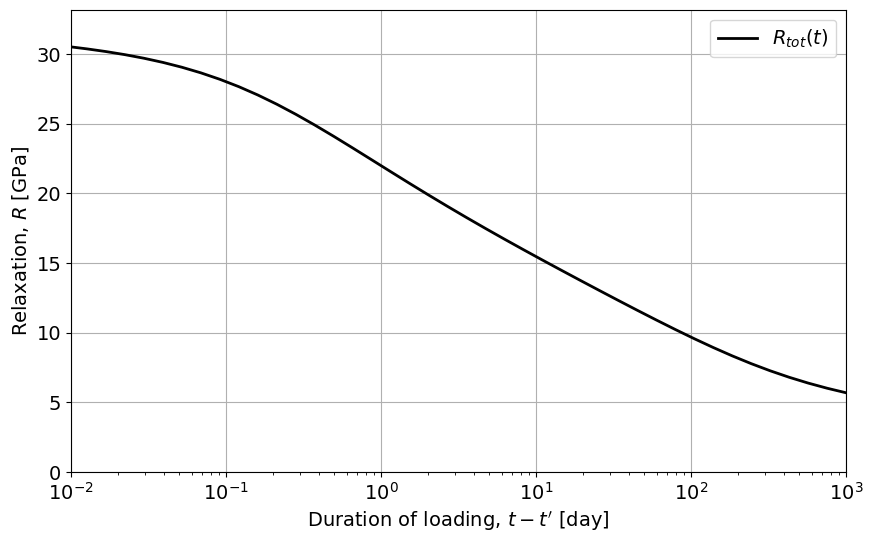

In [16]:
# create array with loading durations [0., 0., logscale with t_div-2 entries]
times = np.logspace( round(math.log10(t_aux_min)-1), round(math.log10(t_aux_max)), num = t_div)
ages = times + tt # duration of loading changed to age

R_tot = evaluate_relaxation_function_at_times(ages)

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})

plt.plot(times, R_tot * 1.e-3, lw=2., color="black", label=r'$R_{tot}(t)$')


if (log_scale):
    plt.xscale('log')
    plt.xlim([t_aux_min, t_aux_max])
else:
    plt.xlim([0., t_aux_max])

# keep top range unbounded
plt.ylim(bottom = 0)

plt.grid(True)
plt.legend()
plt.xlabel('Duration of loading, $t-t\'$ [day]')
plt.ylabel('Relaxation, $R$ [GPa]')

plt.savefig('fib_MC2010_relaxation_function.pdf')

plt.show()


## Plot of total deformation with strain decomposition

In [17]:

# times = np.linspace(0, 200, num = t_div )
# 
# times = np.append(times, [tt-t_aux_min, tt, tt+t_aux_min])
# times = np.append(times, [t0+t_aux_min, t0, t0+t_aux_min])
# # eliminates redundancy and sorts
# times = np.unique(times)
# 
# # local variable redifinition only
# len_times = len(times)
# 
#     
# creep_tot = np.zeros(len_times)
# 
# shr_tot = np.zeros(len_times)
# 
# def_tot = np.zeros(len_times)
# 
#     
# for i in range(len_times):
#     # here t is shifted by the onset of loading
#     t = times[i]
# 
#     shr_tot[i] = compute_mean_total_shrinkage(t) * 1.e6
#     
#     if (t >= tt):
# 
#         creep_tot[i] =  stress * compute_total_compliance_function(t, tt) * -1.e6 
# 
#     def_tot[i] = creep_tot[i] + shr_tot[i]
# 
# 
# plt.figure(figsize=(10,6))
# plt.rcParams.update({'font.size': 14})
# 
# plt.plot(times, creep_tot, lw=2., color="black", label=r"Total creep")
# plt.plot(times, shr_tot, lw=2., color="black", label=r"Total shrinkage", linestyle='dashed')
# plt.plot(times, def_tot, lw=2., color="red", label=r"Total deformation")
# 
# plt.xlim([0., 200])
# 
# # keep top range unbounded
# #plt.ylim(bottom = 0)
# 
# plt.grid(True)
# plt.legend()
# plt.xlabel('Concrete age, $t$ [day]')
# plt.ylabel('Strain, $\epsilon$ [$10^{-6}$]')
# 
# plt.savefig('fib_MC2010_evolution_of_total_strain.pdf')
# 
# plt.show()



## Response to a prescribed shrinkage

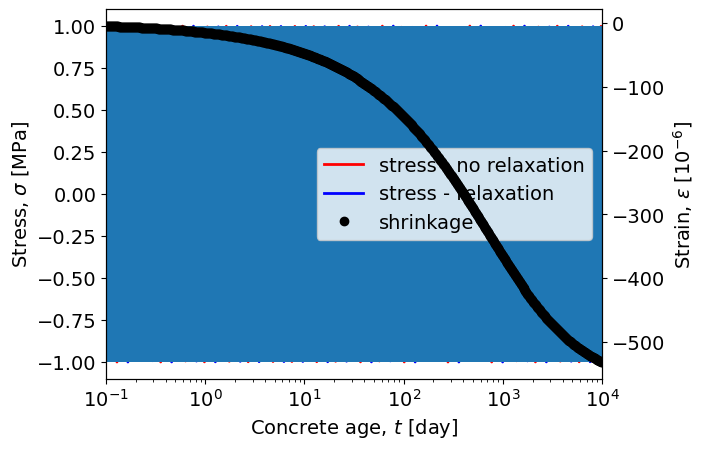

In [55]:

# secant modulus of elasticity of concrete [MPa]
E_cm28 = compute_modulus_of_elasticity(28)

t_div_numer = 500

times_numer = np.logspace(-1, 4, num = t_div_numer )
times_numer += t0

shr = np.zeros(t_div_numer)

for i, t in enumerate(times_numer):
    shr[i] = compute_mean_drying_shrinkage(t) 

sig_tot_relax = np.zeros(t_div_numer)
sig_tot_no_relax = np.zeros(t_div_numer)

for i in range(t_div_numer):
    
    sig_tot_relax[i] = math.cos( i )
    sig_tot_no_relax[i] = math.sin( i )
    

fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 14})

ax2 = ax1.twinx()

lns1 = ax1.plot(times_numer-t0, sig_tot_no_relax, lw=2., color="red", label=r"stress - no relaxation")
lns2 = ax1.plot(times_numer-t0, sig_tot_relax, lw=2., color="blue", label=r"stress - relaxation")
lns3 = ax2.plot(times_numer-t0, shr*1e6, 'o', lw=1., color="black", label=r"shrinkage")

ax1.vlines(times_numer-t0, ymin=-1, ymax=1)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlim([0.1, 1e4])

ax1.set_xlabel('Concrete age, $t$ [day]')
ax1.set_ylabel('Stress, $\sigma$ [MPa]')
ax2.set_ylabel('Strain, $\epsilon$ [$10^{-6}$]')

plt.xscale('log')

plt.savefig('fib_MC2010_evolution_of_shrinkage-induced_stress.pdf')

plt.show()





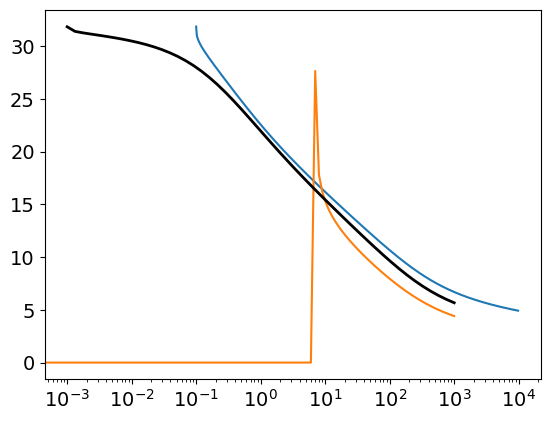

In [65]:
diff_t = times_numer[1:] - times_numer[:-1]
half_time_interval = times_numer[:-1] - t0

# half_time_interval = np.insert(half_time_interval, 0, np.array([0, 1.e-3, 1.e-2, 1.e-1]))
# 
# print(half_time_interval)
R_for = []
t_for = np.linspace(0,1.e3,1000)
for i, t in enumerate(t_for):
    R_for.append(compute_total_relaxation_function(t, tt-t0))

R_for = np.array(R_for)

R = evaluate_relaxation_function_at_times(half_time_interval+tt)

plt.plot(half_time_interval, R*1.e-3,)
plt.plot(t_for, R_for*1.e-3,)
plt.plot(times, R_tot * 1.e-3, lw=2., color="black", label=r'$R_{tot}(t)$')

plt.xscale('log')

In [20]:
def compute_mean_axial_tensile_strength(t: np.ndarray) -> np.ndarray:
    """To avoid division by zero, initiate matrix full of zeros and compute `f_ctm` only at `t`>0."""
    f_ctm = np.zeros(t.shape)
    fctm_28 = 0.3 * fck_28**(2/3)
    beta_cc = np.exp( s * (1. - np.sqrt(28./t[t>0]) ) ) # 5.1-51
    f_ctm[t>0] = beta_cc * fctm_28
    
    return f_ctm

In [21]:
# times = np.linspace(-10, 200, 1000)
# 
# tensile_strength = compute_mean_axial_tensile_strength(times)
# 
# plt.plot(times, tensile_strength)
# # plt.xlim(0, 200)
# plt.ylim(0, 4)

In [22]:
compute_total_relaxation_function(21, 14)

16564.119398358227